In [1]:
import numpy as np
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import pickle

In [2]:
sys.path.append('..')
from tlfair.metrics import *
from tlfair.superlearner import *
from tlfair.knncmi import *

Text(50.722222222222214, 0.5, 'Sample Size')

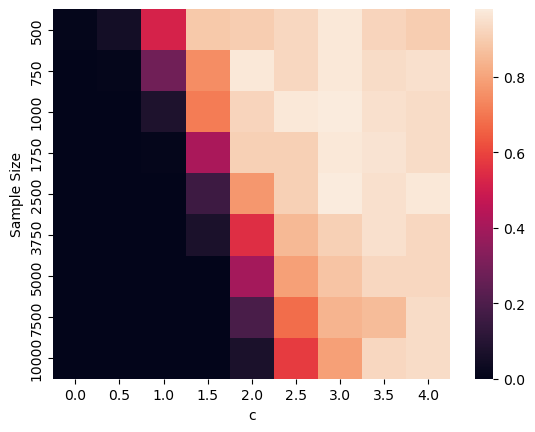

In [3]:
cov_df = pd.read_csv('../cmi_coverage.csv')
plot = cov_df.pivot(index='sample_size', columns='c', values='coverage')
ax = sns.heatmap(plot)
ax.set_ylabel('Sample Size')

In [4]:
cov_df.iloc[np.where(cov_df['sample_size']==1000)]

,Unnamed: 0,sample_size,c,error,coverage
typing.Literal[<no_default>],,,,,
2,0,1000,0.0,-0.064959,0.00
11,0,1000,0.5,-0.063150,0.00
20,0,1000,1.0,-0.052919,0.08
29,0,1000,1.5,-0.032723,0.71
38,0,1000,2.0,-0.017250,0.92
47,0,1000,2.5,-0.006600,0.97
56,0,1000,3.0,-0.011516,0.98
65,0,1000,3.5,-0.007500,0.95
74,0,1000,4.0,-0.003695,0.94


In [4]:
cmp = pd.read_csv('../cmi_compare.csv')
with open('../truth_dict.pkl', 'rb') as f:
    truth = pickle.load(f)
error = []
for i in range(cmp.shape[0]):
    c = cmp['c'][i]
    est = cmp['mean'][i]
    t = truth[c]
    error.append(est - t)
cmp['error'] = error
cmp

,Unnamed: 0,sample size,type,c,mean,bottom_five,top_five,error
0,0,500,TL,0.0,0.001303,-0.013487,0.018155,-0.058533
1,1,500,TL-sep,0.0,-0.123883,-0.161562,-0.074574,-0.183719
2,2,500,KNN,0.0,0.000825,0.000000,0.004540,-0.059011
3,0,500,TL,0.5,0.017149,-0.003258,0.036156,-0.056353
4,1,500,TL-sep,0.5,-0.083454,-0.111916,-0.053218,-0.156956
...,...,...,...,...,...,...,...,...
238,1,10000,TL-sep,3.5,0.359244,0.344662,0.372188,-0.019412
239,2,10000,KNN,3.5,0.366148,0.357839,0.378929,-0.012508
240,0,10000,TL,4.0,0.403947,0.391024,0.416071,-0.002364
241,1,10000,TL-sep,4.0,0.393658,0.383409,0.404674,-0.012653


<Axes: xlabel='c', ylabel='error'>

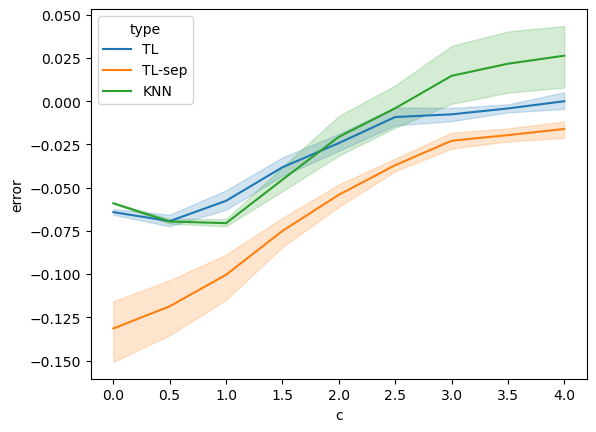

In [6]:
sns.lineplot(data=cmp,
             x='c',
             y = 'error', 
             hue = 'type')

<Axes: xlabel='sample size', ylabel='error'>

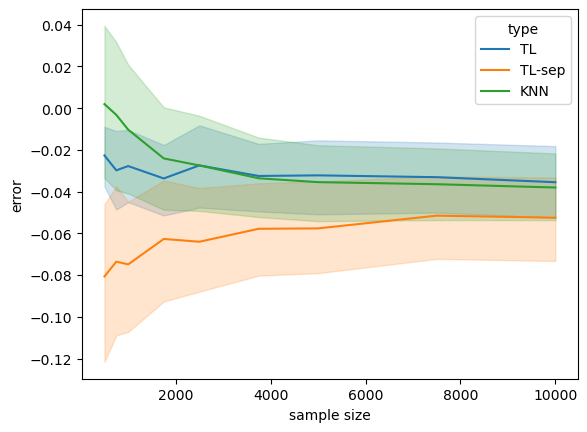

In [7]:
sns.lineplot(data=cmp,
             x='sample size',
             y = 'error', 
             hue = 'type')

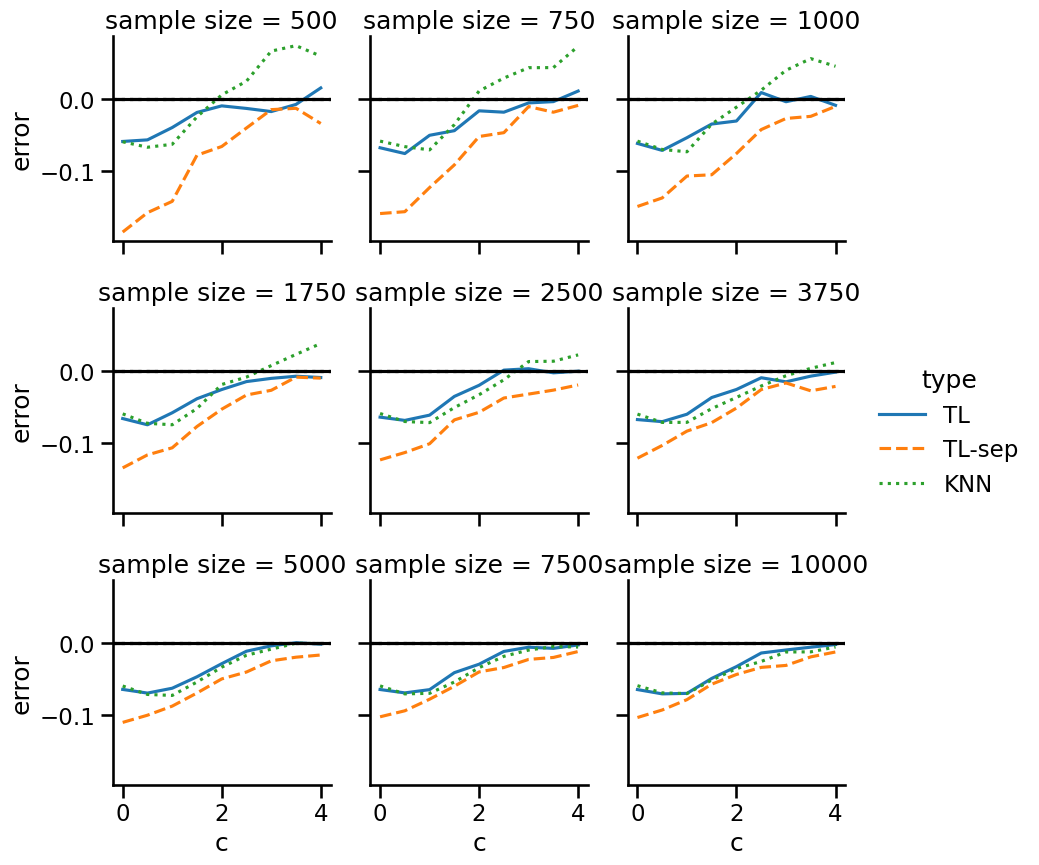

In [5]:
sns.set_context('talk')
d = {'ls': ['-', '--', ':']}
g = sns.FacetGrid(cmp, col='sample size', col_wrap=3, hue='type', hue_kws=d)
g.map_dataframe(sns.lineplot, x='c', y='error')
g.add_legend()
g.map(plt.axhline, y=0, color='black', linestyle='--')

In [9]:
truth

{0: 0.059836399958197284,
 0.5: 0.07350226916489443,
 1: 0.11086454429266947,
 1.5: 0.17119864124278714,
 2: 0.24258611641395927,
 2.5: 0.3004738921624847,
 3: 0.34431542594309844,
 3.5: 0.378655829768966,
 4: 0.40631154437032563}

In [67]:
n = 250
label = np.random.choice(
    a = [0,1,2,3], 
    size = n,
    p = [0.4, 0.1, 0.1, 0.4]
)
x = np.random.poisson(lam=2.0, size=n).reshape(-1,1)
outcome = GradientBoostingClassifier()
outcome = CalibratedClassifierCV(outcome, cv=3).fit(x, label)

est_vec = np.zeros(n)
tol = 1e-2
preds = outcome.predict_proba(x)
for i in range(len(preds)):
    numerator = preds[i, label[i]]
    if label[i] == 0:
        denominator = (preds[i,0]+preds[i,2]) * (preds[i,0]+preds[i,1])
    elif label[i] == 1:
        denominator = (preds[i,1]+preds[i,3]) * (preds[i,0]+preds[i,1])
    elif label[i] == 2:
        denominator = (preds[i,0]+preds[i,2]) * (preds[i,2]+preds[i,3])
    elif label[i] == 3:
        denominator = (preds[i,1]+preds[i,3]) * (preds[i,2]+preds[i,3])
    est_vec[i] = np.log((numerator)/(denominator))
est = np.mean(est_vec)
eif = (est_vec - est)
ci = (est - 1.96*np.sqrt(np.var(eif)/len(eif)), est + 1.96*np.sqrt(np.var(eif)/len(eif)))

In [68]:
print(est)
print(ci)

0.2352288239644058
(0.1592639081622587, 0.31119373976655296)


In [51]:
2*0.4*np.log(0.4/(0.5**2)) + 2*0.1*np.log(0.1/0.5**2)

0.19274475702175753

In [135]:
d = 3
n = 1000
np.random.seed(123)
rng = np.random.default_rng()
z = rng.normal(size=(n,d))
beta = np.ones(d)
c = 2
c_prob = c*rng.uniform(size=n)
x_prob = (c_prob + rng.uniform(size=n) + 1/(1+np.exp(-z@beta)))/(c+2)
y_prob = (c_prob + rng.uniform(size=n) + 1/(1+np.exp(-z@beta)))/(c+2)

x = (x_prob > 0.5).astype(np.int8)
y = (y_prob > 0.5).astype(np.int8)

data = pd.DataFrame(
    data = {
        'x' : x,
        "y" : y,
        "z1" : z[:,0],
        'z2' : z[:,1],
        'z3' : z[:,2]
    }
)
knn_truth = knncmi(['x'], ['y'], ['z1', 'z2', 'z3'], k=7, data=data)
knn_truth

0.005574253919287993

In [7]:
n = 1000
d=3
np.random.seed(123)
rng = np.random.default_rng()
z = rng.normal(size=(n,d))
beta = np.ones(d)
c = 2
c_prob = c*rng.uniform(size=n)
x_prob = (c_prob + rng.uniform(size=n) + 1/(1+np.exp(-z@beta)))/(c+2)
y_prob = (c_prob + rng.uniform(size=n) + 1/(1+np.exp(-z@beta)))/(c+2)

x = (x_prob > 0.5).astype(np.int8)
y = (y_prob > 0.5).astype(np.int8)

label = np.zeros(shape=(len(x),)).astype(np.int8)
label[np.intersect1d(np.where(x==0), np.where(y==0))] = 0
label[np.intersect1d(np.where(x==1), np.where(y==0))] = 1
label[np.intersect1d(np.where(x==0), np.where(y==1))] = 2
label[np.intersect1d(np.where(x==1), np.where(y==1))] = 3

outcome = CalibratedClassifierCV(GradientBoostingClassifier(), cv=3).fit(z, label)

In [162]:
d = 3
n = 10000
np.random.seed(123)
rng = np.random.default_rng()
z = rng.normal(size=(n,d))
beta = np.ones(d)
c = 50
w = 0.95
res = []
for i in range(n):
    inside = 10000
    zi = z[i,:]
    
    c_prob = c*rng.uniform(size=inside)
    x_prob = (c_prob + rng.uniform(size=inside) + 1/(1+np.exp(-z@beta)))/(c+2)
    y_prob = (c_prob + rng.uniform(size=inside) + 1/(1+np.exp(-z@beta)))/(c+2)
    

    '''
    w_prob = w*rng.uniform(size=inside)
    x_prob = (w_prob + ((1-w)/2) *rng.uniform(size=inside) + ((1-w)/2) *1/(1+np.exp(-z@beta)))
    y_prob = (w_prob + ((1-w)/2) *rng.uniform(size=inside) + ((1-w)/2) *1/(1+np.exp(-z@beta)))
    '''
    x = (x_prob > 0.5).astype(np.int8)
    y = (y_prob > 0.5).astype(np.int8)
    

    p1 = np.mean((x==1)*(y==1)) * np.log(np.mean((x==1)*(y==1)) / (np.mean(x==1)*np.mean(y==1)))
    p2 = np.mean((x==0)*(y==1)) * np.log(np.mean((x==0)*(y==1)) / (np.mean(x==0)*np.mean(y==1)))
    p3 = np.mean((x==1)*(y==0)) * np.log(np.mean((x==1)*(y==0)) / (np.mean(x==1)*np.mean(y==0)))
    p4 = np.mean((x==0)*(y==0)) * np.log(np.mean((x==0)*(y==0)) / (np.mean(x==0)*np.mean(y==0)))
    res.append(p1+p2+p3+p4)

ground_truth = np.mean(res)
np.mean(res)

0.546961756980935

In [41]:
def cmi_sim(
    n,
    c,
    d=3,
    rng=None,
    sep=False,
    outcome = GradientBoostingClassifier()
    ):

    n = n //2 #sample splitting
    if rng is None:
        # np.random.seed(123)
        rng = np.random.default_rng()
    z = rng.normal(size=(2*n,d))
    beta = np.array([1,1,1])
    c_prob = c*rng.uniform(size=2*n)
    x_prob = (c_prob + rng.uniform(size=2*n) + 1/(1+np.exp(-z@beta)))/(c+2)
    y_prob = (c_prob + rng.uniform(size=2*n) + 1/(1+np.exp(-z@beta)))/(c+2)
    x = (x_prob > 0.5).astype(np.int8)
    y = (y_prob > 0.5).astype(np.int8)

    

    label = np.zeros(shape=(2*n,)).astype(np.int8)
    label[np.intersect1d(np.where(x==0), np.where(y==0))] = 0
    label[np.intersect1d(np.where(x==1), np.where(y==0))] = 1
    label[np.intersect1d(np.where(x==0), np.where(y==1))] = 2
    label[np.intersect1d(np.where(x==1), np.where(y==1))] = 3

    if sep:
        fn = cmi_separate
    else:
        fn = cmi
        
    res = fn(
        xtr = z[:n,:],
        xte = z[n:,:], 
        ytr = x[:n], 
        yte = x[n:],
        gtr = y[:n],
        gte = y[n:],
        outcome = outcome,
        propensity=None
    )
    return res

def knncmi_sim(
    n,
    c,
    d=3,
    rng=None):
    if rng is None:
        np.random.seed(123)
        rng = np.random.default_rng()
    z = rng.normal(size=(n,d))
    beta = np.array([1,1,1])
    c_prob = c*rng.uniform(size=n)
    x_prob = (c_prob + rng.uniform(size=n) + 1/(1+np.exp(-z@beta)))/(c+2)
    y_prob = (c_prob + rng.uniform(size=n) + 1/(1+np.exp(-z@beta)))/(c+2)

    x = (x_prob > 0.5).astype(np.int8)
    y = (y_prob > 0.5).astype(np.int8)

    data = pd.DataFrame(
        data = {
            'x' : x,
            "y" : y,
            "z1" : z[:,0],
            'z2' : z[:,1],
            'z3' : z[:,2]
        }
    )
    return knncmi(['x'], ['y'], ['z1', 'z2', 'z3'], k=7, data=data)

def cmi_coverage_sim(
    n,
    c,
    ground_truth,
    outcome = GradientBoostingClassifier(),
    sims=100,
    rng=None):

    if rng is None:
        rng = np.random.default_rng(123)
    coverage = np.zeros(sims)
    error = 0
    for i in range(sims):
        res = cmi_sim(n=n, c=c, rng=rng, outcome=outcome)
        error += (res[0] - ground_truth)
        if (res[1][0] <= ground_truth) and (res[1][1] >= ground_truth):
            coverage[i] = 1
    return np.mean(coverage), error/sims

In [194]:
cmi_sim(n=1000, c=2)

(0.29511344535705814, (0.253100871700609, 0.33712601901350725))

In [54]:
weights = [0, 1, 2, 3, 4]
for w in weights:
    res = cmi_coverage_sim(
        n = 1000,
        c = w, 
        ground_truth = truth[w],
        outcome = LogisticRegression(penalty=None))
    print('Results for', w, ':', res)

Results for 0 : (0.0, -0.06861761149767674)
Results for 1 : (0.01, -0.06935591002764938)
Results for 2 : (0.78, -0.03208882711870964)
Results for 3 : (0.97, -0.012786421908456889)
Results for 4 : (0.97, -0.0068156574087971464)


In [164]:
def cmi_ground_truth(
    c,
    d,
    n,
    rng):
    z = rng.normal(size=(n,d))
    beta = np.ones(d)
    res = []
    for i in range(n):
        inside = n
        zi = z[i,:]
        
        c_prob = c*rng.uniform(size=inside)
        x_prob = (c_prob + rng.uniform(size=inside) + 1/(1+np.exp(-z@beta)))/(c+2)
        y_prob = (c_prob + rng.uniform(size=inside) + 1/(1+np.exp(-z@beta)))/(c+2)

        x = (x_prob > 0.5).astype(np.int8)
        y = (y_prob > 0.5).astype(np.int8)
        

        p1 = np.mean((x==1)*(y==1)) * np.log(np.mean((x==1)*(y==1)) / (np.mean(x==1)*np.mean(y==1)))
        p2 = np.mean((x==0)*(y==1)) * np.log(np.mean((x==0)*(y==1)) / (np.mean(x==0)*np.mean(y==1)))
        p3 = np.mean((x==1)*(y==0)) * np.log(np.mean((x==1)*(y==0)) / (np.mean(x==1)*np.mean(y==0)))
        p4 = np.mean((x==0)*(y==0)) * np.log(np.mean((x==0)*(y==0)) / (np.mean(x==0)*np.mean(y==0)))
        res.append(p1+p2+p3+p4)

    return(np.mean(res))

In [201]:
weights = [4]
sizes = [5000]
n_truth = 10000
sims = 5
rng = np.random.default_rng()
results = pd.DataFrame()

for i in range(len(weights)):
    c = weights[i]
    truth = cmi_ground_truth(
        c = c,
        d = 3,
        n = n_truth,
        rng = rng
    )
    for j in range(len(sizes)):
        s = sizes[j]
        r = cmi_coverage_sim(
            n = s,
            c = c,
            ground_truth = truth,
            rng = rng,
            sims = sims
        )
        here = pd.DataFrame(
            {
                "sample_size" : [s],
                "c" : [c],
                "error" : [r[1]],
                "coverage" : [r[0]]
            }
        )
        results = pd.concat([results, here])

In [202]:
results

,sample_size,c,error,coverage
0,5000,4,-0.00709,0.8


In [145]:
rng = np.random.default_rng()
sizes = [250, 500, 1000, 5000, 10000]
coverage = []
for s in sizes:
    r = cmi_coverage_sim(
        n = s,
        c = 4,
        ground_truth=ground_truth,
        sims=5,
        rng = rng
    )
    coverage.append(r[0])
coverage

[1.0, 0.8, 1.0, 1.0, 1.0]

In [196]:
def cmi_compare(
    n,
    repeats = 1,
    params = [0.5, 1, 1.25, 1.5, 1.75, 2, 2.5, 3],
    rng = None):

    if rng is None:
        rng = np.random.default_rng()
    
    df = pd.DataFrame()
    for i in range(len(params)):
        cmi_res = []
        sep_res = []
        knn_res = []
        for _ in range(repeats):
            res = cmi_sim(
                c = params[i],
                n = n,
                rng= rng
            )
            cmi_res.append(res[0])

            res = cmi_sim(
                c = params[i],
                n = n,
                rng= rng,
                sep = True
            )
            sep_res.append(res[0])

            res = knncmi_sim(
                c = params[i],
                n = n,
                rng=rng
            )
            knn_res.append(res)

        data = pd.DataFrame(
            {
                "type": ["TL", "TL-sep", "KNN"],
                "c" : [params[i]] * 3,
                "mean" : [np.mean(cmi_res), np.mean(sep_res), np.mean(knn_res)],
                "bottom_five": [np.quantile(cmi_res, 0.05), np.quantile(sep_res, 0.05), np.quantile(knn_res, 0.05)],
                "top_five" : [np.quantile(cmi_res, 0.95), np.quantile(sep_res, 0.95), np.quantile(knn_res, 0.95)]
            }
        )
        df = df.append(data)
    return df


In [197]:
cmi_compare(n=1000, params=[0,2,4], repeats=5)

,type,c,mean,bottom_five,top_five
0,TL,0,-0.000946,-0.011268,0.009754
1,TL-sep,0,-0.104981,-0.114031,-0.096027
2,KNN,0,0.002591,0.000000,0.007029
0,TL,2,0.233048,0.206262,0.259809
1,TL-sep,2,0.183438,0.134403,0.225137
2,KNN,2,0.235465,0.224361,0.245096
0,TL,4,0.411106,0.394494,0.437186
1,TL-sep,4,0.379008,0.354891,0.420859
2,KNN,4,0.451395,0.425969,0.470827


In [36]:
params = [0.5, 1, 1.25, 1.5, 1.75, 2, 2.5, 3]
n = 1000
rng = np.random.default_rng()
cmi_res = []
sep_res = []
knn_res = []
for i in range(len(params)):
    res = cmi_sim(
        c = params[i],
        n = n,
        rng= rng
    )
    cmi_res.append(res[0])

    res = cmi_sim(
        c = params[i],
        n = n,
        rng= rng,
        sep = True
    )
    sep_res.append(res[0])

    res = knncmi_sim(
        c = params[i],
        n = n,
        rng=rng
    )
    knn_res.append(res)

In [39]:
params = [0.5, 1, 1.25, 1.5, 1.75, 2, 2.5, 3]
n = 1000
rng = np.random.default_rng()
cmi_res = []
sep_res = []
knn_res = []
for i in range(len(params)):
    a = 0
    b = 0
    c = 0
    for _ in range(5):
        res = cmi_sim(
            c = params[i],
            n = n,
            rng= rng
        )
        a += res[0]
        
        res = cmi_sim(
            c = params[i],
            n = n,
            rng= rng,
            sep = True
        )
        b += res[0]

        res = knncmi_sim(
            c = params[i],
            n = n,
            rng=rng
        )
        c += res
        
    cmi_res.append(a/5)
    sep_res.append(b/5)
    knn_res.append(c/5)

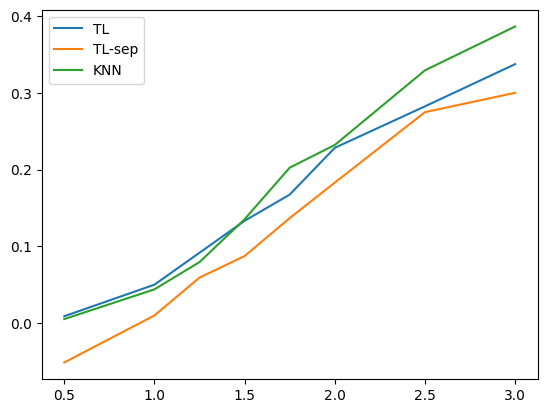

In [40]:
plt.plot(params, cmi_res, label='TL')
plt.plot(params, sep_res, label='TL-sep')
plt.plot(params, knn_res, label='KNN')
plt.legend()